In [232]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [233]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [234]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Read the data

In [260]:
df = pd.read_csv('./Downloads/train.csv')

In [261]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Prepare the Data

First we will drop features that look too complicated to interpret ( we can get back to them later)

In [262]:
df.drop(['PassengerId','Name','Ticket'],1,inplace=True)

categorical features - in the Sex column we will replace males with '1' and females with '0'

In [263]:
df.Sex.replace(['male','female'],[1,0],inplace=True)

In [264]:
#X['Deck'] = X['Cabin'].str[0]
#X['Room_num'] = X['Cabin'].str[1:]
#X.drop('Cabin',1,inplace=True)

for the 'Embarked' column, where we have 3 choises, we will split to 3 column, one for every possible place

In [265]:
df = pd.get_dummies(columns=['Embarked'],data=df)
df.drop('Embarked_Q',1,inplace=True) # to avoid redunduncy

dealing with missing values:

In [266]:
df.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age           177
SibSp           0
Parch           0
Fare            0
Cabin         687
Embarked_C      0
Embarked_S      0
dtype: int64

for a start, we will delete rows/cols with missing values, just to have something to compare to...

In [267]:
df.drop(['Cabin'],1,inplace=True)

In [268]:
df_age = df.copy()
df_age = df_age[df_age.Age.isnull()]
len(df_age)
df_age.drop('Age',1,inplace=True)
df.dropna(0,subset=['Age'],how='any',inplace=True)

In [269]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_S    0
dtype: int64

# logistic regression

In [270]:
log_reg = LogisticRegression()
X = df.drop('Survived',1)
Y = df.Survived
log_reg.fit(X,Y)
scores = cross_val_score(log_reg,X,Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.78 (+/- 0.10)


In [271]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(log_reg.coef_))], axis = 1)
coefficients

,0,0
0,Pclass,-0.895175
1,Sex,-2.397885
2,Age,-0.031395
3,SibSp,-0.307377
4,Parch,-0.056645
5,Fare,0.003954
6,Embarked_C,1.065033
7,Embarked_S,0.685896


we see that age does not seem to influence - but from the exploratory analysis we know it does! just differently for men and women. Sex is the most significant factor, Pclass and Embarked are next. 
next possible things to do here:

lets predict create a separate age column for males and females.

In [272]:
X['Age_male'] = X.Age*(X.Sex==1)
X['Age_female'] = X.Age*(X.Sex==0)

In [273]:
log_reg2 = LogisticRegression()
log_reg2.fit(X,Y)
scores = cross_val_score(log_reg2,X,Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.10)


In [274]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(log_reg2.coef_))], axis = 1)
coefficients

,0,0
0,Pclass,-0.996259
1,Sex,-0.772586
2,Age,-0.017989
3,SibSp,-0.272467
4,Parch,-0.097549
5,Fare,0.002823
6,Embarked_C,1.068501
7,Embarked_S,0.566375
8,Age_male,-0.040265
9,Age_female,0.022277


This is great! already an improvement! let's try to predict the age of the other passengers to increase our dataset. we don't want to use the 'survived' column, because this will be cheating, but in the end we want to use all our data to predict the age. 

In [275]:
age_lin_reg = LinearRegression()
X = df.drop(['Age','Survived'],1)
Y = df.Age
age_lin_reg.fit(X,Y)
scores = cross_val_score(age_lin_reg,X,Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.20 (+/- 0.12)


In [276]:
df_age_drop_surv = df_age.drop('Survived',1)
age_pred = age_lin_reg.predict(df_age_drop_surv)

In [277]:
s= pd.Series(age_pred)
s.describe()

count    177.000000
mean      28.212651
std        9.394848
min       -8.486712
25%       26.079893
50%       28.318867
75%       31.863157
max       42.940720
dtype: float64

In [278]:
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_S
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.406162,2.236695,0.634454,29.699118,0.512605,0.431373,34.694514,0.182073,0.775910
std,0.491460,0.838250,0.481921,14.526497,0.929783,0.853289,52.918930,0.386175,0.417274
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000,8.050000,0.000000,1.000000
50%,0.000000,2.000000,1.000000,28.000000,0.000000,0.000000,15.741700,0.000000,1.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000,33.375000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200,1.000000,1.000000


not bad... lets just change the negative numbers to zero and plug them in. 

In [279]:
age_pred[age_pred<0]=0

In [280]:
df_age['Age']= age_pred
df_age.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_S,Age
5,0,3,1,0,0,8.4583,0,0,31.852818
17,1,2,1,0,0,13.0000,0,1,35.500703
19,1,3,0,0,0,7.2250,1,0,22.832499
26,0,3,1,0,0,7.2250,1,0,26.079953
28,1,3,0,0,0,7.8792,0,0,28.613622


In [281]:
df1 = pd.concat([df,df_age])
df1.isnull().sum()

Age           0
Embarked_C    0
Embarked_S    0
Fare          0
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived      0
dtype: int64

In [221]:
df1['Age_male'] = df1.Age*(df1.Sex==1)
df1['Age_female'] = df1.Age*(df1.Sex==0)

In [282]:
log_reg = LogisticRegression()
X = df1.drop('Survived',1)
Y = df1.Survived
log_reg.fit(X,Y)
scores = cross_val_score(log_reg,X,Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.07)


so we stayed with the same mean accuracy, but lowered the std, which is fine. 
lets just check that this is better than just setting NAs to be the mean age...

In [283]:
df_age['Age']= 30
df_age.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_S,Age
5,0,3,1,0,0,8.4583,0,0,30
17,1,2,1,0,0,13.0000,0,1,30
19,1,3,0,0,0,7.2250,1,0,30
26,0,3,1,0,0,7.2250,1,0,30
28,1,3,0,0,0,7.8792,0,0,30


In [284]:
df1 = pd.concat([df,df_age])
df1.isnull().sum()

Age           0
Embarked_C    0
Embarked_S    0
Fare          0
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived      0
dtype: int64

In [285]:
df1['Age_male'] = df1.Age*(df1.Sex==1)
df1['Age_female'] = df1.Age*(df1.Sex==0)

In [286]:
log_reg = LogisticRegression()
X = df1.drop('Survived',1)
Y = df1.Survived
log_reg.fit(X,Y)
score = log_reg.score(X,Y)
print("Training Accuracy: %0.2f " % (score))
scores = cross_val_score(log_reg,X,Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Training Accuracy: 0.80 
Accuracy: 0.80 (+/- 0.07)


well, look like our age predictor sucks... we can improve it or not use it for now...

# Polinomial features

In [287]:
from sklearn.preprocessing import PolynomialFeatures

In [313]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [314]:
Xpol = poly.fit_transform(X)
Xpol = poly.transform(X)

In [315]:
Xpol = DataFrame(Xpol)
Xpol.columns = poly.get_feature_names(X.columns)
Xpol.head()

,Age,Embarked_C,Embarked_S,Fare,Parch,Pclass,Sex,SibSp,Age_male,Age_female,...,Pclass Sex,Pclass SibSp,Pclass Age_male,Pclass Age_female,Sex SibSp,Sex Age_male,Sex Age_female,SibSp Age_male,SibSp Age_female,Age_male Age_female
0,22.0,0.0,1.0,7.2500,0.0,3.0,1.0,1.0,22.0,0.0,...,3.0,3.0,66.0,0.0,1.0,22.0,0.0,22.0,0.0,0.0
1,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,1.0,0.0,38.0,...,0.0,1.0,0.0,38.0,0.0,0.0,0.0,0.0,38.0,0.0
2,26.0,0.0,1.0,7.9250,0.0,3.0,0.0,0.0,0.0,26.0,...,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35.0,0.0,1.0,53.1000,0.0,1.0,0.0,1.0,0.0,35.0,...,0.0,1.0,0.0,35.0,0.0,0.0,0.0,0.0,35.0,0.0
4,35.0,0.0,1.0,8.0500,0.0,3.0,1.0,0.0,35.0,0.0,...,3.0,0.0,105.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0


In [318]:
log_reg = LogisticRegression()
log_reg.fit(Xpol,Y)
score = log_reg.score(Xpol,Y)
print("Training Accuracy: %0.3f " % (score))
scores = cross_val_score(log_reg,Xpol,Y, cv=10)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Training Accuracy: 0.850 
Accuracy: 0.825 (+/- 0.070)


wow! cool! 
might be overfitted, but overall looks better. 
let's see what made the change...

In [292]:
coefficients = pd.concat([pd.DataFrame(Xpol.columns),pd.DataFrame(np.transpose(log_reg.coef_))], axis = 1)
coefficients.columns = ['feature','weight']
coefficients.sort_values(by='weight').head()

,feature,weight
46,Pclass SibSp,-0.445806
45,Pclass Sex,-0.361681
40,Parch Pclass,-0.354293
29,Embarked_S Pclass,-0.267591
31,Embarked_S SibSp,-0.234375


In [ ]:
coefficients = pd.concat([pd.DataFrame(Xpol3.columns),pd.DataFrame(np.transpose(log_reg.coef_))], axis = 1)
coefficients.columns = ['feature','weight']
coefficients.sort_values(by='weight').tail()

let's try to add regularization...

In [296]:
res = np.zeros([10,4])

In [297]:
res = np.zeros([15,3])
for i in range(15):
    lambd = 2**i/1000
    res[i,0] = lambd
    log_reg = LogisticRegression(penalty='l2', C=1/lambd)
    log_reg.fit(Xpol,Y)
    res[i,1] = log_reg.score(Xpol,Y)
    scores = cross_val_score(log_reg,Xpol,Y, cv=10)
    res[i,2] = scores.mean()

In [299]:
res = DataFrame(res)
res.columns = ['lambda1','train_score','cv_score']
res.head()

,lambda1,train_score,cv_score
0,0.001,0.849607,0.826113
1,0.002,0.849607,0.823815
2,0.004,0.848485,0.826050
3,0.008,0.847363,0.826075
4,0.016,0.851852,0.827186


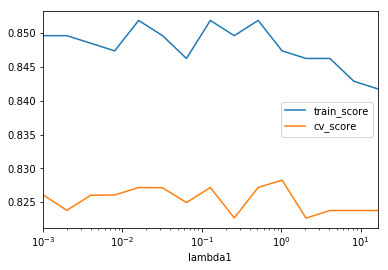

In [300]:
res.plot(x='lambda1',logx=True)

We don't see improvment in CV_score after adding regularization, so it doesn't look like we are suffering from high variance, and we don't really need regularisation. 

Let's see if we are suffering from high variance and whether information about more passengers could help

In [182]:
res = np.zeros([16,3])
for i in range(16):
    n_samples = 90+50*i
    res[i,0] = n_samples
    log_reg = LogisticRegression()
    Xcv = Xpol.head(90)
    Ycv = Y.head(90)
    Xsml = Xpol.tail(n_samples)
    Ysml = Y.tail(n_samples)
    log_reg.fit(Xsml,Ysml)
    res[i,1] = log_reg.score(Xsml,Ysml)
    res[i,2] = log_reg.score(Xcv,Ycv)

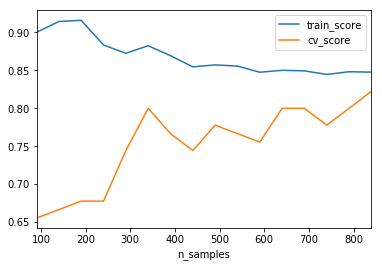

In [183]:
res = DataFrame(res)
res.columns = ['n_samples','train_score','cv_score']
res.plot(x = 'n_samples')

looks like the train score reaches a plato at around 0.85 for this model. the CV score didn't reach a plato yet, but it is close to it, so i think adding much more passengers would not help a lot. 

I noticed that when we created polynomial features, when the value is zero, we don't get information about it. So I think it would be better to create a feature for all zero values.

In [307]:
X1 = X.copy()
X1['male'] = X1.Sex==1
X1['female'] =  X1.Sex==0
X1.drop('Sex',1,inplace=True)
X1['no_SibSp'] = X1.SibSp==0
X1['no_Parch'] =  X1.Parch==0


In [308]:
log_reg.fit(X1,Y)
scores = cross_val_score(log_reg,X,Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.06)


In [344]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Xpol1 = poly.fit_transform(X1)
Xpol1 = poly.transform(X1)
Xpol1 = DataFrame(Xpol1)
Xpol1.columns = poly.get_feature_names(X1.columns)
Xpol1.head()

,Age,Embarked_C,Embarked_S,Fare,Parch,Pclass,SibSp,Age_male,Age_female,male,...,Age_female male,Age_female female,Age_female no_SibSp,Age_female no_Parch,male female,male no_SibSp,male no_Parch,female no_SibSp,female no_Parch,no_SibSp no_Parch
0,22.0,0.0,1.0,7.2500,0.0,3.0,1.0,22.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38.0,1.0,0.0,71.2833,0.0,1.0,1.0,0.0,38.0,0.0,...,0.0,38.0,0.0,38.0,0.0,0.0,0.0,0.0,1.0,0.0
2,26.0,0.0,1.0,7.9250,0.0,3.0,0.0,0.0,26.0,0.0,...,0.0,26.0,26.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0
3,35.0,0.0,1.0,53.1000,0.0,1.0,1.0,0.0,35.0,0.0,...,0.0,35.0,0.0,35.0,0.0,0.0,0.0,0.0,1.0,0.0
4,35.0,0.0,1.0,8.0500,0.0,3.0,0.0,35.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [312]:
log_reg = LogisticRegression()
log_reg.fit(Xpol,Y)
score = log_reg.score(Xpol,Y)
print("Training Accuracy: %0.3f " % (score))
scores = cross_val_score(log_reg,Xpol,Y, cv=10)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Training Accuracy: 0.847 
Accuracy: 0.822 (+/- 0.063)


didn't help much, but was worth trying

In [319]:
coefficients = pd.concat([pd.DataFrame(Xpol.columns),pd.DataFrame(np.transpose(log_reg.coef_))], axis = 1)
coefficients.columns = ['feature','weight']
coefficients.sort_values(by='weight').head()

,feature,weight
46,Pclass SibSp,-0.445806
45,Pclass Sex,-0.361681
40,Parch Pclass,-0.354293
29,Embarked_S Pclass,-0.267591
31,Embarked_S SibSp,-0.234375


# Neural networks!

we get back to the original non polynomial matrix

In [322]:
from sklearn.neural_network import MLPClassifier

In [323]:
clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(100,))

In [326]:
scores = cross_val_score(clf,X,Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.09)


this took some time, but the result is the same...

In [331]:
clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(10,10),alpha = 0.000001)
scores = cross_val_score(clf,X,Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.08)


not too easy to move from here...

In [156]:
NN_arch = [(10,10)]
regularization = [0.000001, 0.00001, 0.0001,0.001, 0.01, 0.1]
accuracy = np.zeros((len(NN_arch),len(regularization)))
for i in range(len(NN_arch)):
    for j in range(len(regularization)):
        clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=NN_arch[i], activation='logistic', alpha=regularization[j],max_iter=20000)
        scores = cross_val_score(clf,X,Y, cv=10)
        accuracy[i,j] = scores.mean()

In [157]:
accuracy

array([[ 0.81605039,  0.79466406,  0.80374135,  0.79350102,  0.8025925 ,
         0.79366587]])

# KNN

In [332]:
from sklearn.neighbors import KNeighborsClassifier

In [337]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X,Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [338]:
train_score = knn.score(X,Y)
print("Train Accuracy: %0.2f " % train_score)
scores = cross_val_score(knn,X,Y, cv=10)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Train Accuracy: 0.87 
CV Accuracy: 0.78 (+/- 0.09)


In [241]:
k_range = range(1, 21)

accuracy = np.zeros((21,3))

In [245]:
for i in k_range: 
    k = 2*i
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xpol, Y)
    train_score = knn.score(Xpol,Y)
    scores = cross_val_score(knn,Xpol,Y, cv=10)
    accuracy[i,0] = k
    accuracy[i,1] = train_score
    accuracy[i,2] = scores.mean()

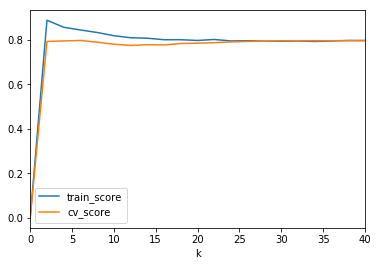

In [246]:
res = DataFrame(accuracy)
res.columns = ['k','train_score','cv_score']
res.plot(x = 'k')

we see that even for polynomial fatures the cv score is reaches a plato at 0.8 -> so logistic regression gives us better results...

# SVM

In [32]:
from sklearn.svm import SVC #support vector classifier

In [45]:
model = SVC()
model.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [46]:
train_score = model.score(X,Y)
print("Train Accuracy: %0.2f " % train_score)
scores = cross_val_score(model,X,Y, cv=10)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Train Accuracy: 0.91 
CV Accuracy: 0.79 (+/- 0.11)


looks like a major overfit...

In [75]:
model = SVC(C=5,gamma=0.001)
model.fit(X,Y)
train_score = model.score(X,Y)
print("Train Accuracy: %0.2f " % train_score)
scores = cross_val_score(model,X,Y, cv=10)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Train Accuracy: 0.82 
CV Accuracy: 0.81 (+/- 0.06)


I wonder whether with polynomial features we can get better results...

In [102]:
model = SVC(C=3,gamma=0.000001)
model.fit(Xpol,Y)
train_score = model.score(Xpol,Y)
print("Train Accuracy: %0.2f " % train_score)
scores = cross_val_score(model,Xpol,Y, cv=10)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Train Accuracy: 0.82 
CV Accuracy: 0.80 (+/- 0.08)


nope...

In [115]:
from sklearn.model_selection import GridSearchCV
parameters = {'gamma':([0.001,0.0001,0.00001]), 'C':[10,100,110]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X, Y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.001, 0.0001, 1e-05], 'C': [10, 100, 110]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [116]:
a = DataFrame(clf.cv_results_)

In [117]:
a

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.066888,0.007347,0.794613,0.831089,10,0.001,"{'C': 10, 'gamma': 0.001}",6,0.794613,0.831650,0.764310,0.840067,0.824916,0.821549,0.029313,0.000931,0.024742,0.007571
1,0.029319,0.006378,0.797980,0.804714,10,0.0001,"{'C': 10, 'gamma': 0.0001}",3,0.804714,0.797980,0.774411,0.818182,0.814815,0.797980,0.003166,0.000315,0.017168,0.009523
2,0.022142,0.007091,0.784512,0.786195,10,1e-05,"{'C': 10, 'gamma': 1e-05}",9,0.794613,0.776094,0.767677,0.804714,0.791246,0.777778,0.001922,0.000650,0.011983,0.013113
3,0.106655,0.005970,0.785634,0.858586,100,0.001,"{'C': 100, 'gamma': 0.001}",7,0.774411,0.855219,0.791246,0.863636,0.791246,0.856902,0.006889,0.000103,0.007936,0.003637
4,0.049133,0.006321,0.810325,0.815376,100,0.0001,"{'C': 100, 'gamma': 0.0001}",1,0.814815,0.813131,0.781145,0.831650,0.835017,0.801347,0.006676,0.000829,0.022221,0.012473
5,0.029080,0.006389,0.796857,0.797419,100,1e-05,"{'C': 100, 'gamma': 1e-05}",4,0.814815,0.794613,0.774411,0.818182,0.801347,0.779461,0.003363,0.000202,0.016798,0.015932
6,0.112388,0.006205,0.785634,0.861392,110,0.001,"{'C': 110, 'gamma': 0.001}",7,0.777778,0.860269,0.791246,0.867003,0.787879,0.856902,0.006551,0.000295,0.005723,0.004199
7,0.053317,0.006204,0.809203,0.815937,110,0.0001,"{'C': 110, 'gamma': 0.0001}",2,0.814815,0.814815,0.777778,0.829966,0.835017,0.803030,0.001771,0.000413,0.023702,0.011025
8,0.026902,0.007207,0.795735,0.799102,110,1e-05,"{'C': 110, 'gamma': 1e-05}",5,0.814815,0.796296,0.771044,0.818182,0.801347,0.782828,0.001659,0.001316,0.018305,0.014569


# Naive Bayes

In [126]:
from sklearn.naive_bayes import GaussianNB

In [128]:
model = GaussianNB()
model.fit(X,Y)
train_score = model.score(X,Y)
print("Train Accuracy: %0.2f " % train_score)
scores = cross_val_score(model,X,Y, cv=10)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Train Accuracy: 0.80 
CV Accuracy: 0.80 (+/- 0.07)


# Decision Tree

In [134]:
model = DecisionTreeClassifier()
model.fit(X,Y)
train_score = model.score(X,Y)
print("Train Accuracy: %0.2f " % train_score)
scores = cross_val_score(model,X,Y, cv=10)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Train Accuracy: 0.98 
CV Accuracy: 0.78 (+/- 0.13)


# Random Forest

In [339]:
model= RandomForestClassifier(n_estimators=100)
model.fit(Xpol,Y)
train_score = model.score(Xpol,Y)
print("Train Accuracy: %0.2f " % train_score)
scores = cross_val_score(model,Xpol,Y, cv=10)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Train Accuracy: 0.98 
CV Accuracy: 0.81 (+/- 0.10)


This looks nice...